In [2]:
!pip install xgboost

Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import sys
import os
import glob

# Hardcode so we can use in any notebook
module_path = "/root/HAIP/services"
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from sharepoint_transfer.src import main as sharepoint_transfer_svc
from data_consolidation.src import main as data_consolidation_svc
from feature_engineering.src import main as feature_engineering_svc
from model_selection.src import main as model_selection_svc
from outcome_analysis.src import main as outcome_analysis_svc
from model_training.src import main as model_training_svc
from final_fitting.src import main as final_fitting_svc
from ensemble_model.src import main as ensemble_model_svc
from model_dataset.src.main import load_dataframe

## Set Measure Specific Settings

These will augment and override settings in "/root/HAIP/notebooks/services/config.json"

In [5]:
settings = {
    # Measure specific options
    "MEASURE_SPECIFIC_FILENAME": "SEP-1.csv",
    "FULL_MEASURE_S3_PREFIX": "SEP-1",
    "filter_measure": "SEP_1", # make sure this is _ not -
    
    "run_save_path": "model_runs",
    "shift_range": range(30, 50), # for isolation_forest
    
    # Feature Engineering options
    "backfill_prov_mean": False, # set to false to not backfill prov mean
    "backfill_lag": False, # set to false to not backfill lag
    "lag_to_add": 2, # add lag1/lag2
}

settings['save_modeling_dataset_path'] = f"/root/HAIP/data/{settings.get('MEASURE_SPECIFIC_FILENAME')}"
settings['model_dataset_path'] = settings['save_modeling_dataset_path']

## Move Sharepoint files to S3

This is not possible in SageMaker Studio because we are trying to figure out Client ID/Secret for the Sharepoint REST API. For now, run the service locally using your own Office365 username/password

## Data Consolidation

Make sure the measure `settings` are changed.


Call `data_consolidation_main.main(settings)`


This will download the full-measure-data in S3, load it into a single data frame, normalize the columns, filter to only include `filter_measure` and then upload the result to S3.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-measure-specific-data?region=us-east-1&tab=objects

In [6]:
# data_consolidation_svc.main(settings)

## Feature Engineering

Call `feature_engineering_main.main(settings)`

This will download the consolidated measure-specific-data in S3, normalize the columns, and add the new features, then upload the result to S3.
Results should also be saved locally automatically, but that is not yet implemented. For now download from the link below and upload the file to SageMaker Studio.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-modeling-dataset?region=us-east-1&tab=objects

In [7]:
# feature_engineering_svc.main(settings)

## XGBoost Regression

### Feature Importance

In [8]:
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression", 
    "drop_cols": ['provider_id'],
}

settings = {**settings, **xgbr_feature_importance_settings}

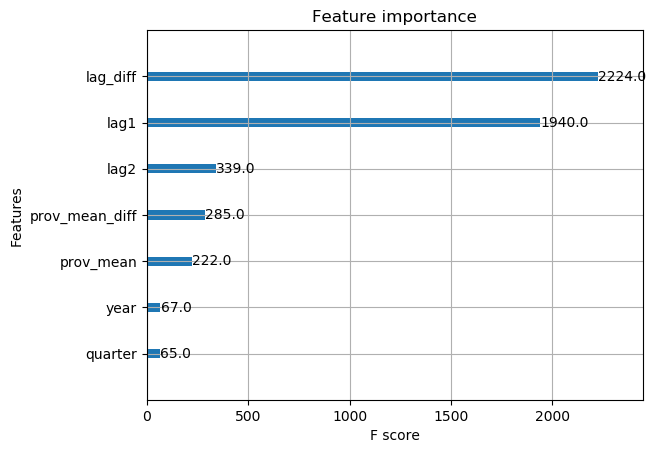

In [9]:
trainer = model_training_svc.get_model_trainer(settings)
trainer.plot_feature_importance()

In [10]:
xgbr_drop_cols = ['provider_id', 'lag2', 'lag_diff', 'prov_mean_diff', 'year', 'quarter']
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression",
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_feature_importance_settings}

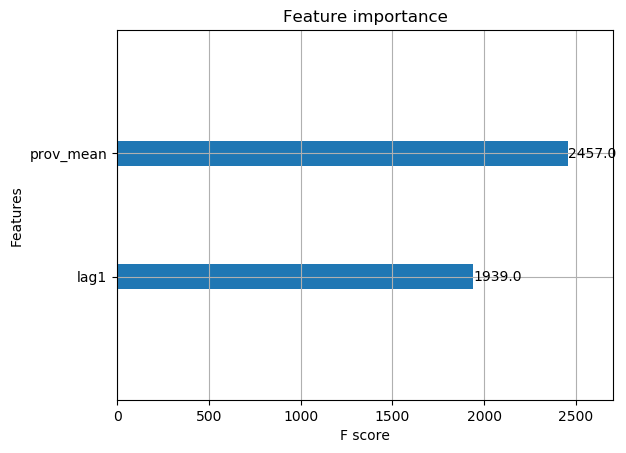

In [11]:
trainer = model_training_svc.get_model_trainer(settings)
trainer.plot_feature_importance()

### Tuning

In [12]:
xgbr_initial_training_settings = {
    "model_type": "XGBRegression", 
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2, 0.3]],
        'gamma': [range(0, 3)],  # [range(0, 2)]
        'max_depth': [range(5, 10)],  # [range(5, 9)]
        'min_child_weight': [range(3, 10)],  # [range(3, 9)]
        'subsample': [[1]],
        'alpha': [[0, 1, 2]]
    },
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_initial_training_settings}

In [13]:
xgbr_trainer = model_training_svc.get_model_trainer(settings)
# candidate = xgbr_trainer.tune()
candidate = None

In [14]:
candidate

### Model Selection

Make sure `model_run_data_path` is set in settings to the tuning result path.
Make sure `model_type` is set in settings to `XGBRegression`, `Isolation Forest`, or `Ensemble`

Call `model_selector = model_selection_main.get_model_selector(settings)` to get the appropriate selector.
Then call `model_selector.get_top_models()` to get the top models

To get the candidate model that matches one of the top_model:
     Call `model_selector.get_candidate_model_by_index(INDEX)` to get the candidate model
     Call `model_selector.get_candidate_model_params_by_index(INDEX)` to get the candidate model params

For `model_run_data_path` right click the file in side nav and choose `Copy Path`. Paste that and add a `/root/` before it.

In [15]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgboost_regression/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgboost_regression/tuning_results_run_2022-11-28-14h25m.csv


In [16]:
xgbr_model_selector = model_selection_svc.get_model_selector(settings)
xgbr_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
422,-6.1666,0.1098,1,1,0.05,0,5,5,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
876,-6.1666,0.1110,2,2,0.05,1,5,4,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
841,-6.1667,0.1105,3,2,0.05,0,5,4,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
842,-6.1668,0.1095,5,2,0.05,0,5,5,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
457,-6.1668,0.1099,4,1,0.05,1,5,5,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 1, 'max_dep..."
913,-6.1669,0.1108,6,2,0.05,2,5,6,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
911,-6.1669,0.1107,7,2,0.05,2,5,4,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
879,-6.1670,0.1098,8,2,0.05,1,5,7,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
492,-6.1670,0.1100,9,1,0.05,2,5,5,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 2, 'max_dep..."
36,-6.1670,0.1107,10,0,0.05,1,5,4,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 1, 'max_dep..."


In [17]:
# xgbr_model_index = 461
xgbr_model_index = xgbr_model_selector.get_top_models().iloc[0].name # default top model
xgbr_model_selector.get_candidate_model_by_index(xgbr_model_index)

mean_fit_time         2.1976
std_fit_time          0.0899
mean_score_time       0.0249
std_score_time        0.0012
param_alpha                1
                       ...  
split48_test_score   -6.2446
split49_test_score    -6.097
mean_test_score      -6.1666
std_test_score        0.1098
rank_test_score            1
Name: 422, Length: 64, dtype: object

In [18]:
xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index)

{'alpha': 1,
 'eta': 0.05,
 'gamma': 0,
 'max_depth': 5,
 'min_child_weight': 5,
 'subsample': 1}

### Final Fit

In [19]:
xgbr_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index),
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_final_fit_settings}

In [20]:
xgbr_fitter = final_fitting_svc.get_final_fitter(settings)
xgbr_model = xgbr_fitter.fit()

In [21]:
xgbr_model

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

## Isolation Forest

### Feature Importance

In [22]:
if_feature_importance_settings = {
    "model_type": "Isolation Forest",
    "drop_cols": ['provider_id'],
}

settings = {**settings, **if_feature_importance_settings}

In [23]:
# trainer = model_training_svc.get_model_trainer(settings)
# trainer.plot_feature_importance()

In [24]:
if_drop_cols = ['provider_id', 'lag2', 'year', 'quarter']
if_feature_importance_settings = {
    "model_type": "Isolation Forest",
    "drop_cols": if_drop_cols,
}

settings = {**settings, **if_feature_importance_settings}

In [25]:
# trainer = model_training_svc.get_model_trainer(settings)
# trainer.plot_feature_importance()

### Tuning

In [26]:
if_training_settings = {
    "model_type": "Isolation Forest", 
    "if_parameters": {
        # Features to include
        'features_included': [['lag_diff', 'prov_mean_diff']],
        # The number of base estimators in the ensemble.
        'n_estimators': [50, 100, 200, 300],
        # The number of samples to draw from X to train each base estimator.
        'max_samples': ['auto', 200, 175, 128],
        # The number of features to draw from X to train each base estimator.
        'max_features': [1],
        # If True, individual trees are fit on random subsets of the training data sampled with replacement.
        # If False, sampling without replacement is performed.
        'bootstrap': [False, True]
    },
    "drop_cols": if_drop_cols, # use just lag1, prov_mean
}

settings = {**settings, **if_training_settings}

In [27]:
if_trainer = model_training_svc.get_model_trainer(settings)
# candidate = if_trainer.tune()
candidate = None

Testing Model #5
Testing Model #10
Testing Model #15
Testing Model #20
Testing Model #25
Testing Model #30
Model tuning complete!


In [28]:
candidate

,model_id,features,model_params,auroc_total,unweighted_aat_score_0.5,weighted_aat_score_0.5,auroc_threshold_0.5,unweighted_aat_score_0.51,weighted_aat_score_0.51,auroc_threshold_0.51,unweighted_aat_score_0.52,weighted_aat_score_0.52,auroc_threshold_0.52,unweighted_aat_score_0.53,weighted_aat_score_0.53,auroc_threshold_0.53,unweighted_aat_score_0.54,weighted_aat_score_0.54,auroc_threshold_0.54,unweighted_aat_score_0.55,weighted_aat_score_0.55,auroc_threshold_0.55,unweighted_aat_score_0.56,weighted_aat_score_0.56,auroc_threshold_0.56,unweighted_aat_score_0.57,weighted_aat_score_0.57,auroc_threshold_0.57,unweighted_aat_score_0.58,weighted_aat_score_0.58,auroc_threshold_0.58,unweighted_aat_score_0.59,weighted_aat_score_0.59,auroc_threshold_0.59,unweighted_aat_score_0.6,weighted_aat_score_0.6,auroc_threshold_0.6,unweighted_aat_score_0.61,weighted_aat_score_0.61,auroc_threshold_0.61,unweighted_aat_score_0.62,weighted_aat_score_0.62,auroc_threshold_0.62,unweighted_aat_score_0.63,weighted_aat_score_0.63,auroc_threshold_0.63,unweighted_aat_score_0.64,weighted_aat_score_0.64,auroc_threshold_0.64,unweighted_aat_score_0.65,weighted_aat_score_0.65,auroc_threshold_0.65
0,1,"['lag_diff', 'prov_mean_diff']","{'bootstrap': False, 'features_included': ['la...",0.994960,0.996910,0.997256,0.913745,0.996200,0.996633,0.924817,0.995140,0.995685,0.935900,0.993520,0.994248,0.943310,0.991545,0.992451,0.948842,0.989830,0.990897,0.953730,0.987975,0.989211,0.958310,0.986220,0.987631,0.962525,0.984320,0.985904,0.965732,0.982070,0.983853,0.967990,0.979850,0.981847,0.970180,0.976900,0.979155,0.971513,0.974165,0.976682,0.972442,0.970120,0.973022,0.972333,0.964090,0.967569,0.970785,0.957455,0.961541,0.969082
1,2,"['lag_diff', 'prov_mean_diff']","{'bootstrap': False, 'features_included': ['la...",0.995333,0.997545,0.997784,0.908175,0.996990,0.997275,0.921230,0.996425,0.996764,0.932552,0.995735,0.996157,0.941335,0.994800,0.995328,0.949730,0.993680,0.994340,0.955490,0.991760,0.992640,0.960313,0.989185,0.990314,0.964035,0.987120,0.988427,0.966992,0.985220,0.986704,0.969690,0.982885,0.984599,0.971550,0.979985,0.981987,0.972720,0.976815,0.979159,0.973538,0.972510,0.975280,0.973330,0.967555,0.970823,0.972518,0.962005,0.965905,0.971098
2,3,"['lag_diff', 'prov_mean_diff']","{'bootstrap': False, 'features_included': ['la...",0.995827,0.997575,0.997800,0.916125,0.997125,0.997395,0.927092,0.996510,0.996857,0.937777,0.995955,0.996367,0.945632,0.995170,0.995682,0.952650,0.994160,0.994787,0.958307,0.992920,0.993708,0.962990,0.990935,0.991927,0.966888,0.988450,0.989700,0.968703,0.985835,0.987317,0.971055,0.983340,0.985050,0.972650,0.980640,0.982602,0.973537,0.977155,0.979485,0.974085,0.973100,0.975826,0.973735,0.969100,0.972256,0.973208,0.963475,0.967182,0.972002
3,4,"['lag_diff', 'prov_mean_diff']","{'bootstrap': False, 'features_included': ['la...",0.995819,0.997545,0.997761,0.916898,0.997170,0.997414,0.928815,0.996625,0.996924,0.938707,0.996070,0.996429,0.946082,0.995320,0.995769,0.952735,0.994355,0.994916,0.958235,0.993050,0.993775,0.962575,0.991135,0.992083,0.966445,0.988730,0.989928,0.968838,0.986140,0.987592,0.970947,0.983380,0.985108,0.972498,0.980765,0.982727,0.973537,0.977600,0.979868,0.974380,0.973545,0.976179,0.974185,0.969545,0.972616,0.973478,0.964145,0.967800,0.972298
4,5,"['lag_diff', 'prov_mean_diff']","{'bootstrap': False, 'features_included': ['la...",0.995404,0.997540,0.997810,0.907500,0.997115,0.997431,0.920767,0.996395,0.996796,0.931498,0.995485,0.995984,0.941195,0.994205,0.994860,0.948455,0.992230,0.993126,0.953947,0.990175,0.991270,0.958643,0.988410,0.989654,0.962557,0.986815,0.988219,0.966102,0.985135,0.986701,0.968525,0.982000,0.983913,0.970002,0.978085,0.980374,0.970568,0.974480,0.977037,0.971557,0.970685,0.973620,0.971675,0.966780,0.970032,0.971380,0.962890,0.966557,0.970487
5,6,"['lag_diff', 'prov_mean_diff']","{'bootstrap': False, 'features_included': ['la...",0.995568,0.997825,0.998047,0.902900,0.997280,0.997553,0.917995,0.996815,0.997136,0.9283

### Model Selection

In [29]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/isolation_forest/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

if_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "Isolation Forest"
}

settings = {**settings, **if_settings}

Using result:  model_runs/isolation_forest/tuning_results_run_2022-11-28-15h02m.csv


In [30]:
if_model_selector = model_selection_svc.get_model_selector(settings)
if_model_selector.get_top_models()

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
6,False,"[lag_diff, prov_mean_diff]",1,200,200,7,0.9959,0.9070,0.9202,0.9317,0.9400,0.9479,0.9546,0.9605,0.9646,0.9672,0.9694,0.9715,0.9729,0.9735,0.9740,0.9737,0.9729
9,False,"[lag_diff, prov_mean_diff]",1,175,100,10,0.9959,0.9007,0.9151,0.9280,0.9376,0.9464,0.9532,0.9586,0.9626,0.9668,0.9699,0.9718,0.9732,0.9737,0.9742,0.9743,0.9728
11,False,"[lag_diff, prov_mean_diff]",1,175,300,12,0.9959,0.9033,0.9164,0.9286,0.9379,0.9463,0.9532,0.9589,0.9630,0.9664,0.9691,0.9709,0.9722,0.9731,0.9739,0.9737,0.9730
19,True,"[lag_diff, prov_mean_diff]",1,auto,300,20,0.9959,0.9167,0.9276,0.9378,0.9459,0.9525,0.9584,0.9630,0.9666,0.9692,0.9712,0.9728,0.9737,0.9743,0.9741,0.9738,0.9727
2,False,"[lag_diff, prov_mean_diff]",1,auto,200,3,0.9958,0.9161,0.9271,0.9378,0.9456,0.9526,0.9583,0.9630,0.9669,0.9687,0.9711,0.9727,0.9735,0.9741,0.9737,0.9732,0.9720
3,False,"[lag_diff, prov_mean_diff]",1,auto,300,4,0.9958,0.9169,0.9288,0.9387,0.9461,0.9527,0.9582,0.9626,0.9664,0.9688,0.9709,0.9725,0.9735,0.9744,0.9742,0.9735,0.9723
7,False,"[lag_diff, prov_mean_diff]",1,200,300,8,0.9958,0.9096,0.9218,0.9332,0.9414,0.9492,0.9559,0.9607,0.9648,0.9676,0.9698,0.9714,0.9726,0.9733,0.9736,0.9734,0.9724
21,True,"[lag_diff, prov_mean_diff]",1,200,100,22,0.9958,0.9041,0.9188,0.9302,0.9405,0.9478,0.9545,0.9598,0.9638,0.9671,0.9696,0.9717,0.9732,0.9735,0.9735,0.9730,0.9719
23,True,"[lag_diff, prov_mean_diff]",1,200,300,24,0.9958,0.9091,0.9220,0.9331,0.9417,0.9493,0.9554,0.9604,0.9647,0.9675,0.9695,0.9715,0.9725,0.9732,0.9734,0.9732,0.9723
27,True,"[lag_diff, prov_mean_diff]",1,175,300,28,0.9958,0.9033,0.9161,0.9281,0.9378,0.9458,0.9525,0.9581,0.9621,0.9652,0.9679,0.9701,0.9713,0.9724,0.9732,0.9732,0.9727


In [31]:
# if_model_id = 6
if_model_id = if_model_selector.get_top_models().iloc[0].model_id # default top model
if_model_selector.get_candidate_model_by_index(if_model_id)

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
6,False,"[lag_diff, prov_mean_diff]",1,200,200,7,0.9959,0.907,0.9202,0.9317,0.94,0.9479,0.9546,0.9605,0.9646,0.9672,0.9694,0.9715,0.9729,0.9735,0.974,0.9737,0.9729


In [32]:
if_model_selector.get_candidate_model_params_by_index(if_model_id)

{'bootstrap': False,
 'features_included': ['lag_diff', 'prov_mean_diff'],
 'max_features': 1,
 'max_samples': 200,
 'n_estimators': 200}

### Final Fit

In [33]:
if_final_fit_settings = {
    "model_type": "Isolation Forest",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "if_final_params": if_model_selector.get_candidate_model_params_by_index(if_model_id),
    "drop_cols": if_drop_cols,
}

del if_final_fit_settings['if_final_params']['features_included']

settings = {**settings, **if_final_fit_settings}

In [34]:
if_fitter = final_fitting_svc.get_final_fitter(settings)
if_model = if_fitter.fit()

In [35]:
if_model

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples=200, n_estimators=200, n_jobs=-1,
                random_state=RandomState(MT19937) at 0x7FA4D9CCDD10, verbose=0,
                warm_start=False)

In [36]:
if_anomaly_scores = if_fitter.get_anomaly_scores()
if_anomaly_scores

array([0.52616452, 0.53036433, 0.53846621, ..., 0.44341108, 0.45412502,
       0.45815465])

## Ensemble Model

### Feature Importance

In [37]:
ensemble_settings = {
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2, 0.3]],
        'gamma': [range(0, 3)],  # [range(0, 2)]
        'max_depth': [range(5, 10)],  # [range(5, 9)]
        'min_child_weight': [range(3, 10)],  # [range(3, 9)]
        'subsample': [[1]],
        'alpha': [[0, 1, 2]]
    },
    "drop_cols": ['provider_id'],
    "if_model": if_model,
    "if_anomaly_scores": if_anomaly_scores,
}

settings = {**settings, **ensemble_settings}

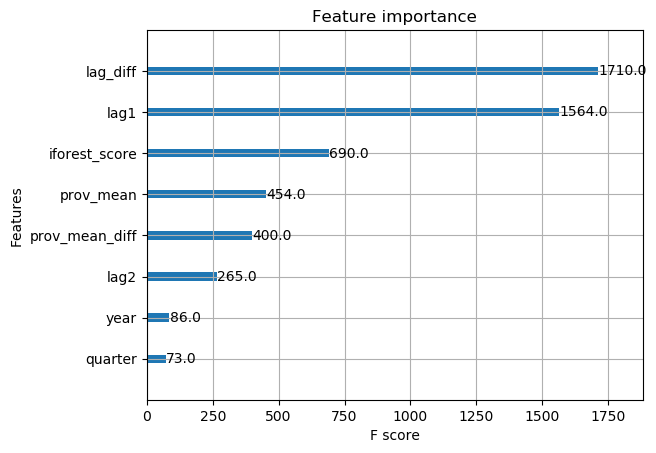

In [38]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

In [39]:
ensemble_drop_cols = ['provider_id', 'lag2', 'prov_mean_diff', 'year', 'quarter', 'lag_diff']
ensemble_settings = {
    "drop_cols": ensemble_drop_cols
}

settings = {**settings, **ensemble_settings}

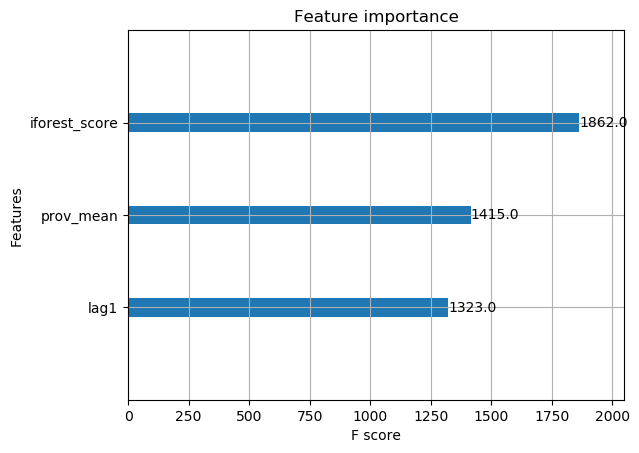

In [40]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

### Tuning

In [41]:
# candidate = ensemble_trainer.tune()
candidate = None
candidate

Fitting 50 folds for each of 1260 candidates, totalling 63000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1952 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3776 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 4512 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 5312 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 6176 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 7104 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 8096 tasks      |

[0]	validation_0-rmse:53.13550
[1]	validation_0-rmse:47.90651
[2]	validation_0-rmse:43.20939
[3]	validation_0-rmse:38.99257
[4]	validation_0-rmse:35.20581
[5]	validation_0-rmse:31.80845
[6]	validation_0-rmse:28.76188
[7]	validation_0-rmse:26.03386
[8]	validation_0-rmse:23.58947
[9]	validation_0-rmse:21.40992


[Parallel(n_jobs=-1)]: Done 63000 out of 63000 | elapsed: 70.7min finished


[10]	validation_0-rmse:19.45975
[11]	validation_0-rmse:17.72624
[12]	validation_0-rmse:16.18003
[13]	validation_0-rmse:14.80850
[14]	validation_0-rmse:13.59583
[15]	validation_0-rmse:12.52326
[16]	validation_0-rmse:11.58636
[17]	validation_0-rmse:10.76590
[18]	validation_0-rmse:10.05003
[19]	validation_0-rmse:9.42483
[20]	validation_0-rmse:8.88496
[21]	validation_0-rmse:8.42215
[22]	validation_0-rmse:8.02802
[23]	validation_0-rmse:7.69338
[24]	validation_0-rmse:7.40899
[25]	validation_0-rmse:7.16440
[26]	validation_0-rmse:6.96417
[27]	validation_0-rmse:6.79631
[28]	validation_0-rmse:6.65429
[29]	validation_0-rmse:6.53509
[30]	validation_0-rmse:6.43926
[31]	validation_0-rmse:6.35467
[32]	validation_0-rmse:6.28997
[33]	validation_0-rmse:6.24283
[34]	validation_0-rmse:6.19886
[35]	validation_0-rmse:6.16562
[36]	validation_0-rmse:6.12713
[37]	validation_0-rmse:6.09453
[38]	validation_0-rmse:6.07053
[39]	validation_0-rmse:6.05669
[40]	validation_0-rmse:6.04505
[41]	validation_0-rmse:6.02874

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,4.767516,1.469758,0.034048,0.010079,0,0.05,0,5,3,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 0, 'max_dep...",-5.822620,-5.881069,-5.830284,-5.917511,-6.020665,-5.780679,-6.019984,-5.853067,-6.073221,-5.752317,-5.784110,-6.015263,-5.974396,-5.896848,-5.892314,-6.032909,-5.677050,-5.844319,-6.151535,-5.725692,-5.789516,-6.097131,-5.701269,-5.899451,-5.936600,-5.948702,-6.084810,-5.899202,-5.839760,-5.838398,-5.909797,-5.833060,-6.120871,-5.613879,-6.041750,-5.998918,-5.706209,-6.059630,-5.852632,-5.820067,-6.077602,-5.924275,-5.983406,-5.850495,-5.809030,-5.984050,-6.040140,-5.664057,-5.930537,-5.871396,-5.901450,0.127407,144
1,4.514729,1.173191,0.032981,0.007955,0,0.05,0,5,4,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 0, 'max_dep...",-5.857512,-5.867035,-5.853597,-5.913863,-6.019037,-5.810275,-6.018966,-5.827586,-6.063210,-5.778683,-5.810694,-5.998421,-5.975786,-5.934940,-5.893206,-6.008154,-5.688721,-5.809163,-6.154268,-5.748619,-5.793067,-6.086172,-5.702360,-5.914732,-5.927954,-5.945242,-6.103063,-5.895696,-5.838048,-5.805819,-5.921942,-5.846207,-6.126637,-5.620086,-6.044454,-6.010102,-5.701922,-6.073587,-5.857707,-5.832096,-6.081461,-5.944008,-5.987400,-5.822298,-5.804123,-5.955016,-6.001421,-5.676637,-5.928680,-5.862591,-5.902845,0.124242,184
2,4.458631,1.146855,0.032550,0.007893,0,0.05,0,5,5,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 0, 'max_dep...",-5.842602,-5.866625,-5.825204,-5.879566,-6.023516,-5.775232,-6.003613,-5.844085,-6.065862,-5.791489,-5.805701,-5.980111,-5.981590,-5.914955,-5.899475,-6.035880,-5.677442,-5.785218,-6.170365,-5.777022,-5.812857,-6.087678,-5.704182,-5.893681,-5.948065,-5.973811,-6.096223,-5.896242,-5.856717,-5.813074,-5.910751,-5.812805,-6.088286,-5.629141,-6.012554,-6.030008,-5.697963,-6.094801,-5.872367,-5.841487,-6.094949,-5.954202,-5.980131,-5.822350,-5.793725,-5.942356,-6.001156,-5.660195,-5.921180,-5.878648,-5.901343,0.125457,141
3,4.862651,1.059499,0.035386,0.007201,0,0.05,0,5,6,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 0, 'max_dep...",-5.825443,-5.855346,-5.872950,-5.865418,-6.002983,-5.769987,-5.997125,-5.816683,-6.065281,-5.765599,-5.800618,-5.989469,-6.001290,-5.881804,-5.856404,-6.015859,-5.701009,-5.808637,-6.163439,-5.730839,-5.776464,-6.092186,-5.719503,-5.901337,-5.907978,-5.968350,-6.077286,-5.914623,-5.821318,-5.803351,-5.912561,-5.832538,-6.093804,-5.605603,-6.016446,-6.035406,-5.695315,-6.095518,-5.868596,-5.833232,-6.082765,-5.923415,-5.949568,-5.842411,-5.796396,-5.941968,-6.005760,-5.697486,-5.916006,-5.886037,-5.895988,0.124552,29
4,4.722912,1.216227,0.034623,0.008445,0,0.05,0,5,7,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 0, 'max_dep...",-5.824280,-5.854259,-5.834334,-5.848609,-6.029227,-5.779811,-6.000101,-5.841499,-6.104144,-5.752034,-5.782102,-5.990829,-5.986716,-5.887249,-5.902758,-6.006234,-5.708822,-5.802639,-6.166408,-5.745172,-5.800461,-6.105046,-5.718872,-5.932586,-5

### Model Selection

In [42]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgbr_ensemble/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgbr_ensemble/tuning_results_run_2022-11-28-15h09m.csv


In [43]:
ensemble_model_selector = model_selection_svc.get_model_selector(settings)
ensemble_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
951,-5.8921,0.1176,1,2,0.10,0,5,9,1,"{'alpha': 2, 'eta': 0.1, 'gamma': 0, 'max_dept..."
1021,-5.8938,0.1197,2,2,0.10,2,5,9,1,"{'alpha': 2, 'eta': 0.1, 'gamma': 2, 'max_dept..."
913,-5.8941,0.1230,3,2,0.05,2,5,6,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
880,-5.8941,0.1244,4,2,0.05,1,5,8,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
566,-5.8942,0.1250,5,1,0.10,1,5,9,1,"{'alpha': 1, 'eta': 0.1, 'gamma': 1, 'max_dept..."
440,-5.8942,0.1277,6,1,0.05,0,7,9,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
986,-5.8945,0.1197,7,2,0.10,1,5,9,1,"{'alpha': 2, 'eta': 0.1, 'gamma': 1, 'max_dept..."
915,-5.8948,0.1245,9,2,0.05,2,5,8,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
601,-5.8948,0.1238,8,1,0.10,2,5,9,1,"{'alpha': 1, 'eta': 0.1, 'gamma': 2, 'max_dept..."
425,-5.8949,0.1217,10,1,0.05,0,5,8,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."


In [44]:
# ensemble_model_index = 895
ensemble_model_index = ensemble_model_selector.get_top_models().iloc[0].name # default top model
ensemble_model_selector.get_candidate_model_by_index(ensemble_model_index)

mean_fit_time         4.7675
std_fit_time          1.4698
mean_score_time        0.034
std_score_time        0.0101
param_alpha                0
                       ...  
split48_test_score   -5.9305
split49_test_score   -5.8714
mean_test_score      -5.9014
std_test_score        0.1274
rank_test_score          144
Name: 0, Length: 64, dtype: object

In [45]:
ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index)

{'alpha': 0,
 'eta': 0.05,
 'gamma': 0,
 'max_depth': 5,
 'min_child_weight': 3,
 'subsample': 1}

### AAT Results (Keep this???)

In [46]:
from artificial_anomaly_tests.aa_tests import artificial_anomaly_test_xgb

threshold_range = range(1,30) #?

artificial_anomaly_test_xgb(
    model = ensemble_trainer.get_model_for_feature_importance(),
    model_data = ensemble_trainer.modeling_df,
    selected_features = list(ensemble_trainer.modeling_df.columns.difference(['score'])),
    shift_range = settings.get('shift_range'),
    threshold_range = threshold_range
)

,Threshold,AUROC
0,1,0.495175
1,2,0.491000
2,3,0.486575
3,4,0.479875
4,5,0.472025
5,6,0.462850
6,7,0.453925
7,8,0.444925
8,9,0.434925


### Final Fit

In [47]:
ensemble_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index),
    "drop_cols": ensemble_drop_cols,
}

settings = {**settings, **ensemble_final_fit_settings}

In [48]:
ensemble_fitter = ensemble_model_svc.get_ensemble_final_fitter(settings)
ensemble_model = ensemble_fitter.fit()

In [49]:
ensemble_model

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

## Outcome Analysis (op10_results_summary-with-ensemble)## Outcome Analysis

In [50]:
outcome_analysis_settings = {
    "if_model": if_model,
    "if_threshold": 0.5,

    "xgbr_model": xgbr_model,
    "xgbr_threshold": 4,
    
    "ensemble_model": ensemble_model,
    "ensemble_threshold": 3,
}

settings = {**settings, **outcome_analysis_settings}

In [51]:
modeling_dataset = load_dataframe(settings.get('model_dataset_path'), []).dropna(subset = ['lag1'])
modeling_dataset['y_quarter'] = modeling_dataset['year'].astype(str) + 'Q' + modeling_dataset['quarter'].astype(str)
modeling_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,y_quarter
1,100001,19.0,18.0,NaN,2017,4,1.0,18.000000,1.000000,2017Q4
2,100001,18.0,19.0,18.0,2018,1,-1.0,18.500000,-0.500000,2018Q1
3,100001,26.0,18.0,19.0,2018,2,8.0,18.333333,7.666667,2018Q2
4,100001,32.0,26.0,18.0,2018,3,6.0,20.250000,11.750000,2018Q3
5,100001,36.0,32.0,26.0,2018,4,4.0,22.600000,13.400000,2018Q4
...,...,...,...,...,...,...,...,...,...,...
42330,90011,59.0,61.0,65.0,2019,4,-2.0,49.222222,9.777778,2019Q4
42331,90011,62.0,59.0,61.0,2020,3,3.0,50.200000,11.800000,2020Q3
42332,90011,62.0,62.0,59.0,2020,4,0.0,51.272727,10.727273,2020Q4
42333,90011,65.0,62.0,62.0,2021,1,3.0,52.166667,12.833333,2021Q1


In [52]:
xgbr_scores = xgbr_model.predict(modeling_dataset[['lag1','prov_mean']])
xgbr_prediction = abs(modeling_dataset['score'] - xgbr_scores) > settings.get('xgbr_threshold')

xgbr_dataset = modeling_dataset.copy()[['score','y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
xgbr_dataset['outlier'] = xgbr_prediction
xgbr_dataset['model_score'] = xgbr_scores
xgbr_dataset['model'] = "XGBoost Regression"
xgbr_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.088560,XGBoost Regression
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.750967,XGBoost Regression
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,True,20.088560,XGBoost Regression
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.869705,XGBoost Regression
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.248066,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
42330,59.0,2019Q4,90011,49.222222,-2.0,9.777778,False,61.393440,XGBoost Regression
42331,62.0,2020Q3,90011,50.200000,3.0,11.800000,False,59.306343,XGBoost Regression
42332,62.0,2020Q4,90011,51.272727,0.0,10.727273,False,61.941525,XGBoost Regression
42333,65.0,2021Q1,90011,52.166667,3.0,12.833333,False,61.895676,XGBoost Regression


In [53]:
if_scores = if_model.score_samples(modeling_dataset.drop(columns=[*if_drop_cols, 'y_quarter'])) * -1
if_prediction = if_scores > settings.get('if_threshold')

if_dataset = modeling_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
if_dataset['outlier'] = if_prediction
if_dataset['model_score'] = if_scores
if_dataset['model'] = "Isolation Forest"
if_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,True,0.526165,Isolation Forest
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,True,0.530364,Isolation Forest
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,True,0.538466,Isolation Forest
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,True,0.515457,Isolation Forest
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,0.499288,Isolation Forest
...,...,...,...,...,...,...,...,...,...
42330,59.0,2019Q4,90011,49.222222,-2.0,9.777778,False,0.444381,Isolation Forest
42331,62.0,2020Q3,90011,50.200000,3.0,11.800000,False,0.448470,Isolation Forest
42332,62.0,2020Q4,90011,51.272727,0.0,10.727273,False,0.443411,Isolation Forest
42333,65.0,2021Q1,90011,52.166667,3.0,12.833333,False,0.454125,Isolation Forest


In [54]:
ensemble_dataset = modeling_dataset.copy()[['lag1','prov_mean','score']]
ensemble_dataset['iforest_scores'] = if_scores
ensemble_scores = ensemble_model.predict(ensemble_dataset[['iforest_scores','lag1','prov_mean']])
ensemble_prediction = abs(ensemble_dataset['score'] - ensemble_scores) > settings.get('ensemble_threshold')

ensemble_dataset = modeling_dataset.copy()[['score', 'year','quarter', 'provider_id','prov_mean','lag_diff','prov_mean_diff']]
ensemble_dataset['outlier'] = ensemble_prediction
ensemble_dataset['model_score'] = ensemble_scores
ensemble_dataset['model'] = "Ensemble Model"
ensemble_dataset

,score,year,quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,19.0,2017,4,100001,18.000000,1.0,1.000000,True,42.350605,Ensemble Model
2,18.0,2018,1,100001,18.500000,-1.0,-0.500000,True,41.453705,Ensemble Model
3,26.0,2018,2,100001,18.333333,8.0,7.666667,True,42.350605,Ensemble Model
4,32.0,2018,3,100001,20.250000,6.0,11.750000,True,44.475384,Ensemble Model
5,36.0,2018,4,100001,22.600000,4.0,13.400000,True,47.523041,Ensemble Model
...,...,...,...,...,...,...,...,...,...,...
42330,59.0,2019,4,90011,49.222222,-2.0,9.777778,True,41.507275,Ensemble Model
42331,62.0,2020,3,90011,50.200000,3.0,11.800000,True,41.412800,Ensemble Model
42332,62.0,2020,4,90011,51.272727,0.0,10.727273,True,41.185860,Ensemble Model
42333,65.0,2021,1,90011,52.166667,3.0,12.833333,True,41.185860,Ensemble Model


In [55]:
import pandas as pd

comparison_df = pd.concat([xgbr_dataset, if_dataset, ensemble_dataset], axis = 0)
comparison_df['model'] = comparison_df['model'].astype('category')
comparison_df['model'] = comparison_df['model'].cat.reorder_categories(['XGBoost Regression','Isolation Forest', 'Ensemble Model'])
comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,year,quarter
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.088560,XGBoost Regression,NaN,NaN
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.750967,XGBoost Regression,NaN,NaN
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,True,20.088560,XGBoost Regression,NaN,NaN
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.869705,XGBoost Regression,NaN,NaN
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.248066,XGBoost Regression,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42330,59.0,NaN,90011,49.222222,-2.0,9.777778,True,41.507275,Ensemble Model,2019.0,4.0
42331,62.0,NaN,90011,50.200000,3.0,11.800000,True,41.412800,Ensemble Model,2020.0,3.0
42332,62.0,NaN,90011,51.272727,0.0,10.727273,True,41.185860,Ensemble Model,2020.0,4.0
42333,65.0,NaN,90011,52.166667,3.0,12.833333,True,41.185860,Ensemble Model,2021.0,1.0


### ??? Rest is graphics and explanations, how much do we copy here?